
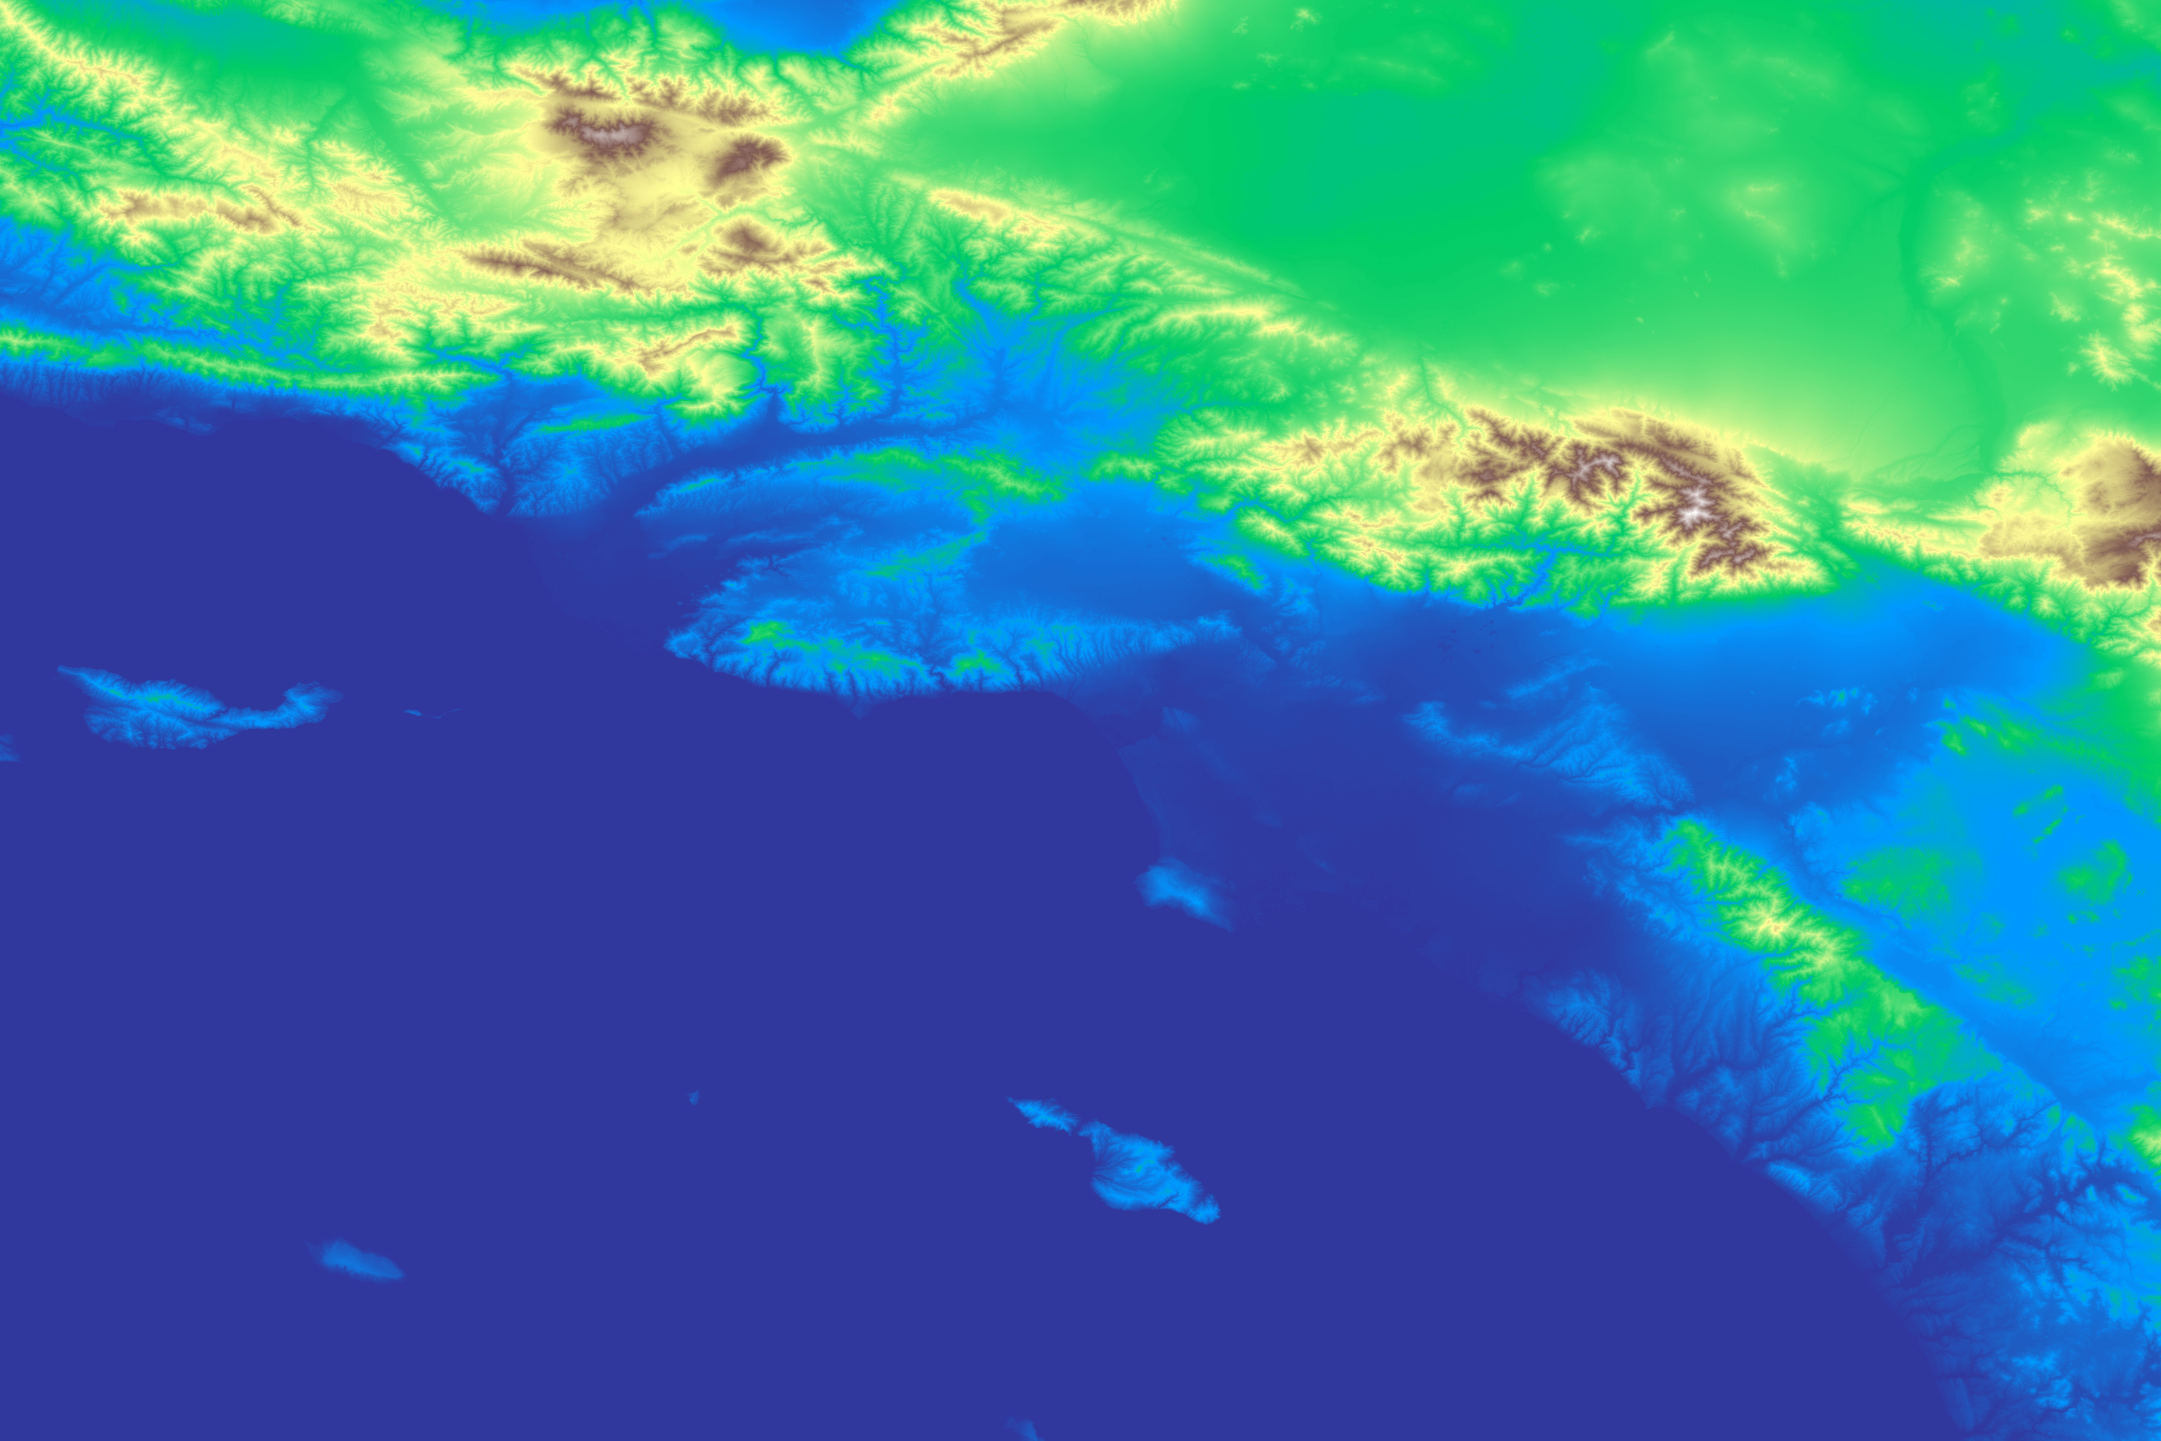

In [1]:
import rasterio
from rasterio.merge import merge
from rasterio.transform import array_bounds
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.raster_layers import ImageOverlay
import io 
import base64

# List your .hgt files here
files = [
    "data/n33w118.hgt", "data/n33w119.hgt", "data/n33w120.hgt",
    "data/n34w118.hgt", "data/n34w119.hgt", "data/n34w120.hgt"
]

# Open and merge the files
src_files_to_mosaic = [rasterio.open(fp) for fp in files]
mosaic, out_trans = merge(src_files_to_mosaic)
src_crs = src_files_to_mosaic[0].crs

# Choose a decimation factor; e.g., factor of 5 reduces the number of rows and cols by 5
factor = 5
downsampled = mosaic[:, ::factor, ::factor]

# Update the transform to account for the decimation
# Multiplying the resolution by the factor gives the new resolution.
new_transform = out_trans * out_trans.scale(factor, factor)

# Save an image for visualization: Normalize the elevation values to 0-255
elev = downsampled[0]
normed = (elev - np.nanmin(elev)) / (np.nanmax(elev) - np.nanmin(elev))
image_8bit = (normed * 255).astype(np.uint8)

buf = io.BytesIO()
plt.imsave(buf, image_8bit, cmap='terrain')
buf.seek(0)
image_data = base64.b64encode(buf.read()).decode('utf-8')
data_url = 'data:image/png;base64,' + image_data




# Compute bounds for the downsampled raster
rows, cols = downsampled.shape[1], downsampled.shape[2]
bounds = array_bounds(rows, cols, new_transform)
folium_bounds = [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]

# Create a Folium map centered on the raster data
center_lat = (folium_bounds[0][0] + folium_bounds[1][0]) / 2
center_lon = (folium_bounds[0][1] + folium_bounds[1][1]) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add the image overlay
overlay = ImageOverlay(
    name="Elevation",
    image="downsampled_intuitive.png",
    bounds=folium_bounds,
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
)
overlay.add_to(m)
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m


In [18]:
import pandas as pd

# Get row and column indices
rows, cols = np.meshgrid(np.arange(downsampled.shape[1]), np.arange(downsampled.shape[2]), indexing="ij")

# Convert to coordinates using the new transform
xs, ys = rasterio.transform.xy(new_transform, rows, cols)

# Flatten arrays
xs_flat = np.array(xs).flatten()
ys_flat = np.array(ys).flatten()
heights_flat = downsampled[0].flatten()  # Extract elevation values

# Create DataFrame
df = pd.DataFrame({
    "latitude": ys_flat,
    "longitude": xs_flat,
    "height (m)": heights_flat
})

# Save to CSV
df.to_csv("downsampled_elevation.csv", index=False)

print("CSV file saved successfully!")


CSV file saved successfully!


In [25]:
from PIL import Image
matrix= downsampled[0]
matrix.shape

(1441, 2161)

In [36]:
image_rgb = Image.fromarray(image_8bit)
image_rgb.show()  # Display image


In [29]:
rgb_matrix = np.stack([matrix] * 3, axis=-1)  # Shape becomes (1441, 2161, 3)

# Create an RGB image
image_rgb = Image.fromarray(rgb_matrix, mode="RGB")
image_rgb.show()


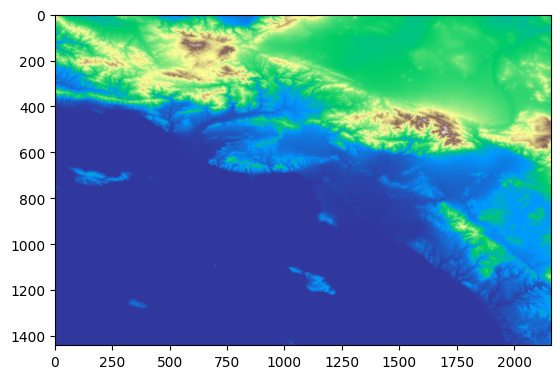

In [44]:
terrain_overlay= plt.imshow(image_8bit,cmap='terrain')

In [49]:
import io
image_pil = Image.fromarray(image_8bit)
img_io = io.BytesIO()
image_pil.save(img_io, format="PNG")
img_io.seek(0)



0

In [50]:
m2 = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add the image overlay
overlay = ImageOverlay(
    name="Elevation",
    image=img_io,
    bounds=folium_bounds,
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
)
overlay.add_to(m2)
# folium.LayerControl().add_to(m2)
m2

TypeError: Object of type BytesIO is not JSON serializable

In [ ]:
band = mosaic[0]
from rasterio.features import shapes

# Create a mask for valid data (using the nodata value from one of the source files)
nodata = src_files_to_mosaic[0].nodata
mask = band != nodata

# Extract shapes and corresponding elevation values from the raster
features = []
for geom, val in shapes(band, mask=mask, transform=out_trans):
    feature = {
        "type": "Feature",
        "geometry": geom,
        "properties": {"elevation": float(val)}
    }
    features.append(feature)

# Create a GeoJSON FeatureCollection
geojson = {"type": "FeatureCollection", "features": features}
